#NPB Statistics

## Utils

### Imports

In [1]:
import sys
import argparse
import math
import numpy as np
from scipy.stats import t
import scipy.stats as stats
import csv
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Global variables

In [3]:
##Global variables
#VER_PYTHON_SERIAL="PYTHON-SERIAL"
#VER_CPP_SERIAL="CPP-SERIAL"
#VER_PYTHON_CUDA="PYTHON-CUDA"
#VER_CUDA="CPP-CUDA"
#VER_OPENACC="CPP-OPENACC"
#VER_RTM_INTEL="RTM-INTEL"
VER_RTM_INTEL_R1="RTM-INTEL-r1"
VER_RTM_INTEL_R50="RTM-INTEL-r50"
VER_RTM_INTEL_R500="RTM-INTEL-r500"
VER_STM_TINY="STM-TINY"
VER_STM_SWISS="STM-SWISS"
VER_SEQ="SEQ"

#VERSIONS_SERIAL = [VER_PYTHON_SERIAL, VER_CPP_SERIAL]
#VERSIONS_GPU = [VER_PYTHON_CUDA, VER_CUDA, VER_OPENACC]
#VERSIONS = [VER_HTM_INTEL, VER_STM_TINY]
#VERSIONS = [VER_RTM_INTEL, VER_SEQ]
VERSIONS = []
#fullVerList = [VER_RTM_INTEL, VER_STM_TINY, VER_STM_SWISS, VER_SEQ]
fullVerList = [VER_RTM_INTEL_R1, VER_RTM_INTEL_R50, VER_RTM_INTEL_R500, VER_STM_TINY, VER_STM_SWISS, VER_SEQ]

#----Talvez trocar os nomes pra só "Lo" e "Hi" pra parar de ficar torto as tabelas----
##CLASSES = ["B", "C"]
#CLASSES = ["LoContention", "HiContention"]
CLASSES = []
#fullClssList = ["LoContention", "HiContention"]
fullClssList = ["Low", "High"]

##BENCHS = ["BT", "CG", "EP", "FT", "IS", "LU", "MG", "SP"]
#BENCHS = ["bayes", "genome", "intruder", "kmeans", "labyrinth", "ssca2", "vacation", "yada"]
#BENCHS = ["bayes", "genome", "kmeans", "labyrinth", "intruder", "yada"]
BENCHS = []
fullBnchList = ["bayes", "genome", "intruder", "kmeans", "labyrinth", "ssca2", "vacation", "yada"]

#Para facilmente poder remover algum, listar os que devem ser ignorados da lista criada com base no arquivo
#ignoreVer = [VER_RTM_INTEL, VER_STM_TINY]
#ignoreClss = ["LoContention"]
#ignoreBnch = ["bayes", "genome", "kmeans", "labyrinth", "ssca2", "vacation"]

ignoreVer = ["SEQ"]
ignoreClss = []
ignoreBnch = []

fileName = "/content/drive/MyDrive/Colab Notebooks/Arquivos/tratado"
with open(fileName) as f:
  file = f.read()
  if(("RTM-INTEL-r1" in file) and not("RTM-INTEL-r1" in ignoreVer)):
    VERSIONS.append(VER_RTM_INTEL_R1)
  if(("RTM-INTEL-r50" in file) and not("RTM-INTEL-r50" in ignoreVer)):
    VERSIONS.append(VER_RTM_INTEL_R50)
  if(("RTM-INTEL-r500" in file) and not("RTM-INTEL-r500" in ignoreVer)):
    VERSIONS.append(VER_RTM_INTEL_R500)
  if(("STM-TINY" in file) and not("STM-TINY" in ignoreVer)):
    VERSIONS.append(VER_STM_TINY)
  if(("STM-SWISS" in file) and not("STM-SWISS" in ignoreVer)):
    VERSIONS.append(VER_STM_SWISS)
  if(("SEQ" in file) and not("SEQ" in ignoreVer)):
    VERSIONS.append(VER_SEQ)

  #for clss in fullClssList:
  #  if((clss in file) and not(clss in ignoreClss)):
  #    CLASSES.append(clss)
  for clss in fullClssList:
    if((clss in file) and not(clss in ignoreClss)):
      CLASSES.append(clss)

  for Bnch in fullBnchList:
    if((Bnch in file) and not(Bnch in ignoreBnch)):
      BENCHS.append(Bnch)

dic_dados = {}
dic_dados_bench = {}
g_bench = ""

### Statistical methods

In [4]:
# CSV
def le_csv_desempenho(arquivos, prefixo, array_dados):
	if len(arquivos) < 1:
		return
	for a in arquivos:
		with open(a) as f:
			reader = csv.reader(f, delimiter=';', quoting=csv.QUOTE_NONE)
			filtro = list(filter(lambda x: len(x) > 0 and x[0] == prefixo, reader))
			
			for linha in filtro:
				array_dados.append(linha[1:])
#END

def split(dado):
	aux = dado.split("=")
	if len(aux) == 2:
		return aux[1]
	return dado
#END

# DICTIONARY
def name_versao(versao):
	if "RTM" in versao:
		if "INTEL" in versao:
			if "r500" in versao:
				return "RTM-500"
			if "r50" in versao:
				return "RTM-50"
			if "r1" in versao:
				return "RTM-1"
		elif "IBM" in versao:
			return "IBM"
	elif "STM" in versao:
		if "TINY" in versao:
			return "TinySTM"
		elif "SWISS" in versao:
			return "SwissTM"
	elif "SEQ" in versao:
		return "Sequential"
		
	#if "PYTHON" in versao:
	#	if "SERIAL" in versao:
	#		return "Python"
	#	elif "CUDA" in versao:
	#		return "Numba"
	#elif "OPENACC" in versao:
	#	return "OpenACC"
	#elif "CPP" in versao:
	#	if "SERIAL" in versao:
	#		return "C++"
	#	elif "CUDA" in versao:
	#		return "Cuda"
	
	return ""
 #END  

def idx_dicionario(versao, classe):
	return versao + "_$$_" + classe

##Classe, size e gpus acho que não é necessário
def add_dicionario(dic, idx, desc, classe, size, iteraction, cpus, gpus, times):
	dic[idx] = {}
	dic[idx]["desc"] = desc
	dic[idx]["class"] = classe
	dic[idx]["size"] = size
	dic[idx]["iteraction"] = iteraction
	dic[idx]["cpus"] = cpus
	dic[idx]["gpus"] = gpus
	dic[idx]["times"] = times
#END

#Statiscs
def calc_stats(amostra):
	# confidence interval of 95%
	tdist = t.ppf(0.95, len(amostra)-1)
	mean = np.mean(amostra)
	std = np.std(amostra)
	error = tdist*(std/math.sqrt(len(amostra)))
	return mean, std, error

def report_df(data):
	mean, std, error = calc_stats(data)
	data_sort = sorted(data)
	sz = len(data)
	
	ks_stat, ks_p, ks_p_ok = ks_gaussian_test(data)
	sw_stat, sw_p, sw_p_ok = shapiro_wilk_gaussian_test(data)
	
	print("%12s %15.8f" %("count", sz))
	print("%12s %15.8f" %("mean", mean))
	print("%12s %15.8f" %("std", std))
	print("%12s %15.8f" %("error (95%)", error))
	print("%12s %15.8f" %("min", min(data)))
	print("%12s %15.8f" %("25%", max(data_sort[: (int(sz*0.25) if int(sz*0.25) > 1 else 1)]) ) )
	print("%12s %15.8f" %("50%", max(data_sort[:int(sz*0.50)]) ) )
	print("%12s %15.8f" %("75%", max(data_sort[:int(sz*0.75)]) ) )
	print("%12s %15.8f" %("max", max(data)))
	print("%12s %15.8f" %("KS stat", ks_stat))
	print("%12s %15.8f" %("KS p", ks_p))
	print("%12s %15s" %( ("KS p>0.05", "Sample OK" if ks_p_ok else "Sample Bad") ))
	print("%12s %15.8f" %("SW stat", sw_stat))
	print("%12s %15.8f" %("SW p", sw_p))
	print("%12s %15s" %( ("SW p>0.05", "Sample OK" if sw_p_ok else "Sample Bad") ))
#END

def report_df_all(dic):
	column_0 = ["count", "mean", "std", "error (95%)", "min", "25%", "50%", "75%", "max", 
				"KS stat", "KS p", "KS p>0.05", "SW stat", "SW p", "SW p>0.05"]
	
	rows = []
	rows.append([])
	i = 0
	for c in column_0:
		rows[i].append("%12s" % (c))
		rows.append([])
		i += 1
	
	header = []
	header.append("%12s" % (""))
	for idx, dados in dic.items():
		header.append("%15s" % (dados["desc"] + " - " + dados["class"]))
		
		data = dados["times"]
		mean, std, error = calc_stats(data)
		data_sort = sorted(data)
		sz = len(data)
		
		ks_stat, ks_p, ks_p_ok = ks_gaussian_test(data)
		sw_stat, sw_p, sw_p_ok = shapiro_wilk_gaussian_test(data)
		
		rows[0].append("%15.8f" %(sz))
		rows[1].append("%15.8f" %(mean))
		rows[2].append("%15.8f" %(std))
		rows[3].append("%15.8f" %(error))
		rows[4].append("%15.8f" %(min(data)))
		rows[5].append("%15.8f" %(max(data_sort[: (int(sz*0.25) if int(sz*0.25) > 1 else 1)])))
		rows[6].append("%15.8f" %(max(data_sort[:int(sz*0.50)])))
		rows[7].append("%15.8f" %(max(data_sort[:int(sz*0.75)])))
		rows[8].append("%15.8f" %(max(data)))
		rows[9].append("%15.8f" %(ks_stat))
		rows[10].append("%15.8f" %(ks_p))
		rows[11].append("%15s" %( ("Sample OK" if ks_p_ok else "Sample Bad") ))
		rows[12].append("%15.8f" %(sw_stat))
		rows[13].append("%15.8f" %(sw_p))
		rows[14].append("%15s" %( ("Sample OK" if sw_p_ok else "Sample Bad") ))
	
	for i in range(len(column_0)):
		if i == 0:
			print(header[0], end="")
			j = 1
			for idx in dic.items():
				print(header[j], end="")
				j += 1
			print()
		
		j = 0
		for idx, dados in dic.items():
			if j == 0:
				print(rows[i][j], end="")
				j += 1
			
			print(rows[i][j], end="")
			j += 1
		print()
#END


def ks_gaussian_test(data):
	loc, scale = stats.norm.fit(data)
	n = stats.norm(loc=loc, scale=scale)

	stat, p = stats.kstest(data, n.cdf)

	alpha = 0.05
	return stat, p, (p > alpha)
#END

def ks_gaussian_teste_chart(data):
	loc, scale = stats.norm.fit(data)
	n = stats.norm(loc=loc, scale=scale)

	plt.hist(data, rwidth=0.5)
	#x = numpy.arange(min(data), max(data) + 0.2, 0.02)
	#plt.plot(x, data.mean()*n.pdf(x))
	plt.title('Comparação Entre Histograma e Projeção da Distribuição Normal')
	plt.title('Histograma da Distribuição')
	plt.xlabel('Tempo de Execução')  
	plt.ylabel('Número de Ocorrências')

	plt.show()

	stat, p = stats.kstest(data, n.cdf)
	print('Statistics=%.5f, p=%.5f' % (stat, p))

	alpha = 0.05
	if p > alpha:
		print('Sample looks Gaussian (fail to reject H0)')
	else:
		print('Sample does not look Gaussian (reject H0)')
#END

def shapiro_wilk_gaussian_test(data):
	stat, p = stats.shapiro(data)
	
	alpha = 0.05
	return stat, p, (p > alpha)
#END

# generate boxplot containing all columns from two dataframes (side by side comparison)
def boxplot_chart(data, version):
	data_set = [data]
	fig, ax = plt.subplots()
	
	#Plot boxplot
	bp = ax.boxplot(data_set, widths=0.25, patch_artist = True)

	# changing color and linewidth of whiskers
	for whisker in bp['whiskers']:
		whisker.set(color ='#8B008B', linewidth = 1.5, linestyle =":")
 
	# changing color and linewidth of caps
	for cap in bp['caps']:
		cap.set(color ='#8B008B', linewidth = 2)
 
	# changing color and linewidth of medians
	for median in bp['medians']:
		median.set(color ='red', linewidth = 3)
 
	# changing style of fliers
	for flier in bp['fliers']:
		flier.set(marker ='D', color ='#e7298a', alpha = 0.5)
	
	# changing color
	colors = ['#0000FF', '#00FF00', '#FFFF00', '#FF00FF'] #Support for 4 series
	for patch, color in zip(bp['boxes'], colors):
		patch.set_facecolor(color)
		
	plt.xticks([1], [version])
	plt.ylabel('Execution time (s)')

	fig.tight_layout()
	plt.show()
#END


# apply student t test comparing two statistics
# Null Hypothesis (H0): µa = µb (the means of both populations are equal)
# Alternate Hypothesis (Ha): µa ≠ µb (the means of both populations are not equal)
def student_t_test(pop_a, pop_b):
	t_stat, p_value = stats.ttest_ind(pop_a, pop_b, equal_var=False)
	return t_stat, p_value, (p_value <= 0.05)
#END

def student_t_test_report(pop_a, pop_b):
	t_stat, p_value, p_value_ok = student_t_test(pop_a, pop_b)
	
	print("P-Value={0} T-Statistic={1}".format(p_value, t_stat))

	#if p_value <= 0.05:
	if p_value_ok:
		print('The mean of the samples is different (reject H0)')
	else:
		print('The mean of the samples is equal (fail to reject H0)')
#END

def mann_whitney_u_test(pop_a, pop_b):
	t_stat, p_value = stats.mannwhitneyu(pop_a, pop_b, use_continuity=False, alternative='two-sided')
	return t_stat, p_value, (p_value <= 0.05)
#END

def mann_whitney_u_test_report(pop_a, pop_b):
	t_stat, p_value, p_value_ok = mann_whitney_u_test(pop_a, pop_b)

	print("P-Value={0} T-Statistic={1}".format(p_value,t_stat))

	#if p_value <= 0.05:
	if p_value_ok:
		print('The mean of the samples is different (reject H0)')
	else:
		print('The mean of the samples is equal (fail to reject H0)')
#END

def t_u_tests_report_all(dic, versions): #Versions is a matrix [[v1, v2], [v2, v3]...]
	column_0 = ["KS OK?", "T-Test p", "T-Test stat", "T-Test p<=0.05",
						"U-Test p", "U-Test stat", "U-Test p<=0.05"]
	
	rows = []
	rows.append([])
	i = 0
	for c in column_0:
		rows[i].append("%15s" % (c))
		rows.append([])
		i += 1
	
	header = []
	header.append("%15s" % (""))
	for v in versions:
		dic_a = dic[v[0]]
		pop_a = dic_a["times"]
		
		dic_b = dic[v[1]]
		pop_b = dic_b["times"]
		
		head = "(" + dic_a["desc"] + "[" + dic_a["class"] + "]) x (" + dic_b["desc"] + "[" + dic_b["class"] + "])"
		header.append("%27s" % (head))
		
		
		a_ks_stat, a_ks_p, a_ks_p_ok = ks_gaussian_test(pop_a)
		b_ks_stat, b_ks_p, b_ks_p_ok = ks_gaussian_test(pop_b)
		ks_ok = (a_ks_p_ok and b_ks_p_ok)
		
		t_stat, t_p_value, t_p_value_ok = student_t_test(pop_a, pop_b)
		
		u_stat, u_p_value, u_p_value_ok = mann_whitney_u_test(pop_a, pop_b)
		
		rows[0].append("%27s" % ( ("Yes" if ks_ok else "No") ))
		rows[1].append("%27.12e" % (t_p_value))
		rows[2].append("%27.8f" % (t_stat))
		t_test_app = ("T-Test OK" if t_p_value_ok else "T-Test Failed") if ks_ok else "Not normally distrib."
		rows[3].append("%27s" % ( t_test_app ))
		rows[4].append("%27.12e" % (u_p_value))
		rows[5].append("%27.8f" % (u_stat))
		rows[6].append("%27s" % ( ("U-Test OK" if u_p_value_ok else "U-Test Failed") ))
		
	for i in range(len(column_0)):
		if i == 0:
			print(header[0], end="")
			for j in range(1, len(versions)+1):
				print(header[j], end="")
			print()
		
		for j in range(0, len(versions)+1):
			print(rows[i][j], end="")

		print()
#END

### Load dictionary

In [5]:
def load_data_dictionary(bench):
    global g_bench
    g_bench = bench

    # Load dictionary
    dados = [] # array das linhas

    #le_csv_desempenho(["sample_data/exec_20220224_BT.txt", "sample_data/exec_20210924_EP.txt", 
    #                   "sample_data/exec_20210929_CG.txt", "sample_data/exec_20210930_FT.txt", 
    #                   "sample_data/exec_20211001_MG.txt", "sample_data/exec_20220227_LU.txt", 
    #                   "sample_data/exec_20211001_IS.txt", "sample_data/exec_20220226_SP.txt"], "BENCH=" + bench, dados)
    #le_csv_desempenho(["/content/sample_data/exec_20210924_EP.txt"], "BENCH=" + bench, dados)
    #le_csv_desempenho(["/content/sample_data/tratado"], "BENCH=" + bench, dados)

    le_csv_desempenho(["/content/drive/MyDrive/Colab Notebooks/Arquivos/tratado"], "BENCH=" + bench, dados)

    bench_process_data(dados, bench)

### Benchmark Methods

In [6]:
def bench_time_chart():
	times = []
	class_ids = range(1, len(CLASSES)+2, 2)
	
	max_time = 0
	#for v in VERSIONS_GPU:
	for v in VERSIONS:
		#if g_bench == "IS" and "OPENACC" in v:
		#	continue
		
		v_time = []
		
		#time, a, b = calc_stats(dic_dados[idx_dicionario(v, "LoContention")]["times"])
		time, a, b = calc_stats(dic_dados[idx_dicionario(v, "Low")]["times"])
		v_time.append(time)
		max_time = max(time, max_time)
		
		#if "HiContention" in CLASSES:
		if "High" in CLASSES:
			#time, a, b = calc_stats(dic_dados[idx_dicionario(v, "HiContention")]["times"])
			time, a, b = calc_stats(dic_dados[idx_dicionario(v, "High")]["times"])
			v_time.append(time)
			max_time = max(time, max_time)
		
		times.append(v_time)
		
	#Chart
	#desenha as barras no gráfico
	fig, ax = plt.subplots()
	
	bars = []
	#idx = -0.3
	idx = (1.5/len(times)) 
	value = idx * -(math.floor(len(times)/2))
	for t in times:
		bar = ax.bar(np.array(class_ids)+value, np.array(t), width=0.25)
		bars.append(bar)
		value += idx

	ax.set_xlabel('Classes')
	ax.set_ylabel('Execution time (s)')
	ax.set_xlim(0, 4)
	ax.set_ylim(0, math.ceil(max_time))
	
	#ax.title('Execution time') 
	ax.legend(tuple(map(name_versao, VERSIONS)))
	
	ax.set_xticks(class_ids)
	ax.set_xticklabels(CLASSES)
	
	#for b in bars:
	#	ax.bar_label(b, padding=3, fmt='%5.3f')

	fig.tight_layout()

	plt.show() #mostra o gráfico
#END

def bench_speedup_chart(version_serial, versions_gpu):
	speedups = []
	class_ids = range(1, len(CLASSES)+2, 2)
	#class_ids = range((4/len(CLASSES)),(4/len(CLASSES))*2)
	
	#time_serial_B, a, b = calc_stats(dic_dados[idx_dicionario(version_serial, "B")]["times"])
	#time_serial_C, a, b = calc_stats(dic_dados[idx_dicionario(version_serial, "C")]["times"])
	#if "LoContention" in CLASSES:
	#	time_serial_Lo, a, b = calc_stats(dic_dados[idx_dicionario(version_serial, "LoContention")]["times"])
	#if "HiContention" in CLASSES:
	#	time_serial_Hi, a, b = calc_stats(dic_dados[idx_dicionario(version_serial, "HiContention")]["times"])
	if "Low" in CLASSES:
		time_serial_Lo, a, b = calc_stats(dic_dados[idx_dicionario(version_serial, "Low")]["times"])
	if "High" in CLASSES:
		time_serial_Hi, a, b = calc_stats(dic_dados[idx_dicionario(version_serial, "High")]["times"])
	
	max_speedup = 0
	for v in versions_gpu:
		v_speedup = []
		
		#if "LoContention" in CLASSES:	
		#	time, a, b = calc_stats(dic_dados[idx_dicionario(v, "LoContention")]["times"])
		if "Low" in CLASSES:	
			time, a, b = calc_stats(dic_dados[idx_dicionario(v, "Low")]["times"])
			speedup = time_serial_Lo/time
			v_speedup.append(speedup)
			max_speedup = max(speedup, max_speedup)
		
		#if "HiContention" in CLASSES:	
		#	time, a, b = calc_stats(dic_dados[idx_dicionario(v, "HiContention")]["times"])
		if "High" in CLASSES:	
			time, a, b = calc_stats(dic_dados[idx_dicionario(v, "High")]["times"])
			speedup = time_serial_Hi/time
			v_speedup.append(speedup)
			max_speedup = max(speedup, max_speedup)
		
		speedups.append(v_speedup)
		
	#Chart
	#desenha as barras no gráfico
	fig, ax = plt.subplots()
	
	bars = []
	#idx = 0.30 if len(speedups) > 1 else 0.0
	idx = 1.5/len(speedups) if len(speedups) > 1 else 0.0
	value = idx * -(math.floor(len(speedups)/2))
	for s in speedups:
		bar = ax.bar(np.array(class_ids)+value, np.array(s), width=0.25)
		bars.append(bar)
		value += idx

	ax.set_xlabel('Classes')
	ax.set_ylabel('Speedup')
	ax.set_xlim(0, 4)
	ax.set_ylim(0, math.ceil(max_speedup*1.1))
	
	#ax.title('Speedup') 
	ax.legend(tuple(map(name_versao, versions_gpu)))
	
	ax.set_xticks(class_ids)
	ax.set_xticklabels(CLASSES)
	
	#for b in bars:
	#	ax.bar_label(b, padding=3)

	fig.tight_layout()

	plt.show() #mostra o gráfico
#END

def bench_report_t_u_tests(classe):
	versoes_comp = []

	#versoes_comp.append([idx_dicionario(VER_PYTHON_SERIAL, classe), idx_dicionario(VER_PYTHON_CUDA, classe)])
	#versoes_comp.append([idx_dicionario(VER_RTM_INTEL, classe), idx_dicionario(VER_SEQ, classe)])
	
	#versoes_comp.append([idx_dicionario(VER_RTM_INTEL, classe), idx_dicionario(VER_STM_TINY, classe)])
	versoes_comp.append([idx_dicionario(VERSIONS[0], classe), idx_dicionario(VERSIONS[1], classe)])
	#for v in VERSIONS:
	#	versoes_comp.append(idx_dicionario(v, classe))

	#versoes_comp.append([idx_dicionario(VER_CPP_SERIAL, classe), idx_dicionario(VER_CUDA, classe)])
	#if g_bench != "IS":
	#	versoes_comp.append([idx_dicionario(VER_CPP_SERIAL, classe), idx_dicionario(VER_OPENACC, classe)])
	#	versoes_comp.append([idx_dicionario(VER_CUDA, classe), idx_dicionario(VER_OPENACC, classe)])
	#versoes_comp.append([idx_dicionario(VER_PYTHON_CUDA, classe), idx_dicionario(VER_CUDA, classe)])
	#if g_bench != "IS":
	#	versoes_comp.append([idx_dicionario(VER_PYTHON_CUDA, classe), idx_dicionario(VER_OPENACC, classe)])

	#print(versoes_comp)
	#print(dic_dados)
	t_u_tests_report_all(dic_dados, versoes_comp)
#END

def bench_calc_stats(dados, versao, classe, threads=0, gpus=0):
	global dic_dados
	
	idx_versao = 0
	idx_classe = 1
	idx_size = 2
	idx_iter = 3
	idx_threads = 4
	idx_gpus = 5
	idx_time = 6
	linhas = list(filter(lambda x: versao in split(x[idx_versao]) and classe in split(x[idx_classe]), dados))
	
	if len(linhas) > 0:
		times = [float(split(l[idx_time])) for l in linhas]
		add_dicionario(dic_dados, idx_dicionario(versao, classe), name_versao(versao), classe, 
#		               split(linhas[0][idx_size]), split(linhas[0][idx_iter]), threads, gpus, times) 
		               split(linhas[0][idx_size]), split(linhas[0][idx_iter]), split(linhas[0][idx_threads]), gpus, times)
#END

def bench_process_data(dados, bench):
	print("Gerando", bench, "...")
	
	for c in CLASSES:
		for v in VERSIONS:
			bench_calc_stats(dados, v, c, 1, 0)
			
		#for v in VERSIONS_GPU:
		#	if bench == "IS" and "OPENACC" in v:
		#		continue
		#	bench_calc_stats(dados, v, c, 0, 1)
	
	print(bench, "OK")
#END

def bench_apply_ks_tests(classe):
	for idx, value in dic_dados.items():
		if value["class"] == classe:
			print('----------', value["desc"], "-", value["class"], '----------')
			ks_gaussian_teste_chart(value["times"])
			print()	
#END

def bench_apply_boxplots(classe):
	for idx, value in dic_dados.items():
		if value["class"] == classe:
			print('----------', value["desc"], "-", value["class"], '----------')
			boxplot_chart(value["times"], value["desc"] + " - " + value["class"])
			print()	
#END



## Main Benchmark

In [7]:
##Parameter: BT | CG | EP | FT | IS | LU | MG | SP
##load_data_dictionary("EP")

for b in BENCHS:
  load_data_dictionary(b)

Gerando bayes ...
bayes OK
Gerando genome ...
genome OK
Gerando intruder ...
intruder OK
Gerando kmeans ...
kmeans OK
Gerando labyrinth ...
labyrinth OK
Gerando ssca2 ...
ssca2 OK
Gerando vacation ...
vacation OK
Gerando yada ...
yada OK


### Report DF

In [8]:
report_df_all(dic_dados)

                RTM-1 - Low   RTM-50 - Low  RTM-500 - Low  TinySTM - Low  SwissTM - Low   RTM-1 - High  RTM-50 - High RTM-500 - High TinySTM - High SwissTM - High
       count    30.00000000    37.00000000     7.00000000    30.00000000    30.00000000    30.00000000    37.00000000     7.00000000    30.00000000    30.00000000
        mean     0.15813333     0.71324324     2.23342857     0.09640000     0.10370000     8.06883460    50.74735327   166.43853400    17.55868447    17.34454050
         std     0.00084591     0.73444623     0.00955969     0.00055377     0.00069041     0.07509578    56.02583192     9.10472888     0.12975196     0.15426650
 error (95%)     0.00026241     0.20384881     0.00702115     0.00017179     0.00021418     0.02329597    15.55021806     6.68699645     0.04025123     0.04785605
         min     0.15700000     0.35300000     2.22200000     0.09600000     0.10300000     7.97327700    23.36720200   162.08470700    17.38628100    17.14186900
         25%     0.158

### KS Test

#### Low Contention

---------- RTM-1 - Low ----------


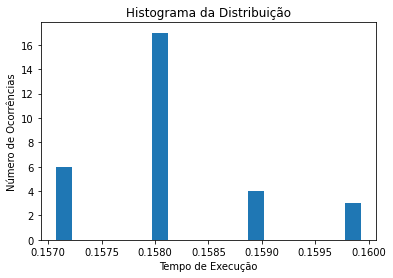

Statistics=0.32929, p=0.00212
Sample does not look Gaussian (reject H0)

---------- RTM-50 - Low ----------


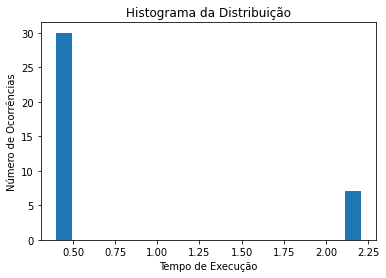

Statistics=0.46948, p=0.00000
Sample does not look Gaussian (reject H0)

---------- RTM-500 - Low ----------


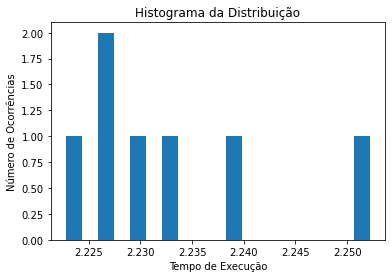

Statistics=0.21150, p=0.85449
Sample looks Gaussian (fail to reject H0)

---------- TinySTM - Low ----------


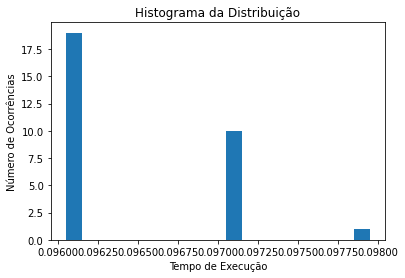

Statistics=0.39828, p=0.00008
Sample does not look Gaussian (reject H0)

---------- SwissTM - Low ----------


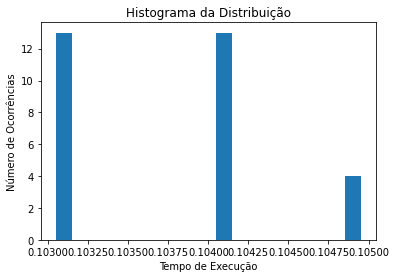

Statistics=0.27802, p=0.01529
Sample does not look Gaussian (reject H0)



In [9]:
#bench_apply_ks_tests("B")
#bench_apply_ks_tests("LoContention")
bench_apply_ks_tests("Low")

#### High Contention

---------- RTM-1 - High ----------


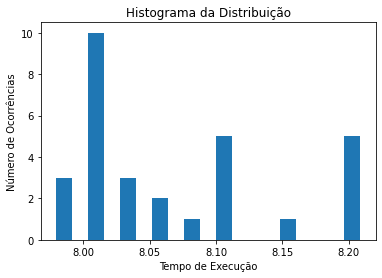

Statistics=0.21769, p=0.09966
Sample looks Gaussian (fail to reject H0)

---------- RTM-50 - High ----------


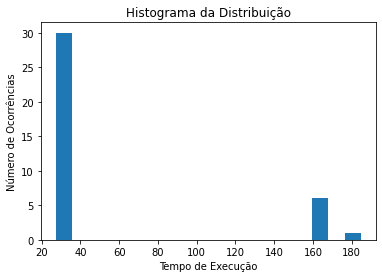

Statistics=0.48628, p=0.00000
Sample does not look Gaussian (reject H0)

---------- RTM-500 - High ----------


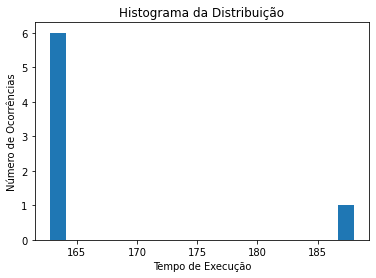

Statistics=0.47456, p=0.05733
Sample looks Gaussian (fail to reject H0)

---------- TinySTM - High ----------


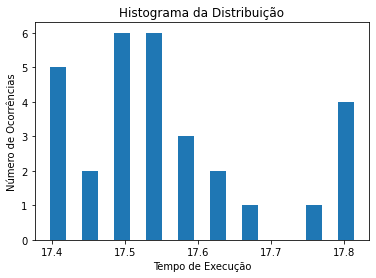

Statistics=0.19474, p=0.17978
Sample looks Gaussian (fail to reject H0)

---------- SwissTM - High ----------


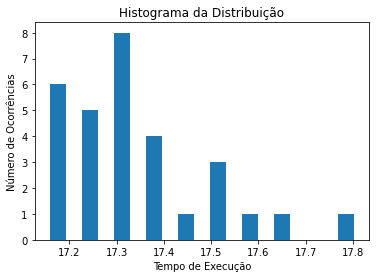

Statistics=0.14981, p=0.46644
Sample looks Gaussian (fail to reject H0)



In [10]:
##bench_apply_ks_tests("C")
#bench_apply_ks_tests("HiContention")
bench_apply_ks_tests("High")

### Boxplots

#### Low Contention

---------- RTM-1 - Low ----------


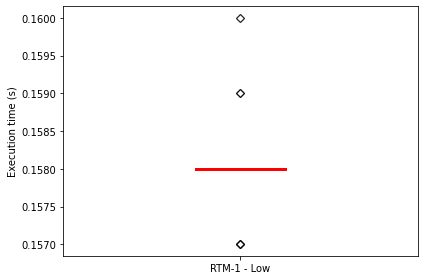


---------- RTM-50 - Low ----------


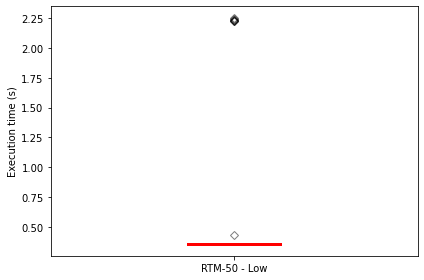


---------- RTM-500 - Low ----------


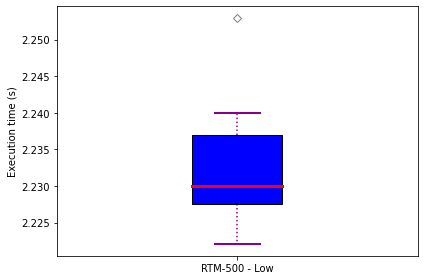


---------- TinySTM - Low ----------


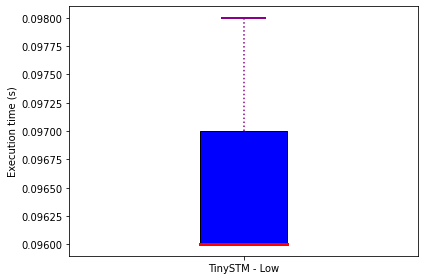


---------- SwissTM - Low ----------


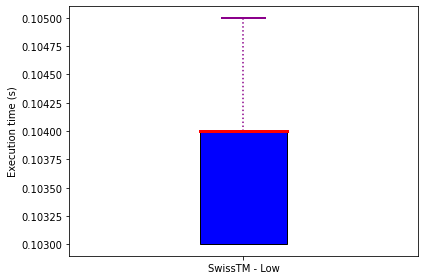

In [11]:
#bench_apply_boxplots("B")
#bench_apply_boxplots("LoContention")
bench_apply_boxplots("Low")

#### High Contention

---------- RTM-1 - High ----------


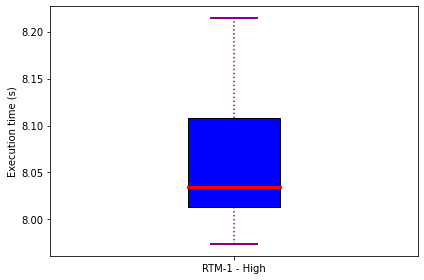


---------- RTM-50 - High ----------


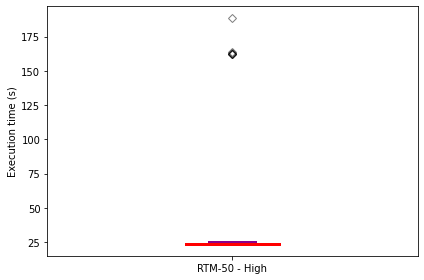


---------- RTM-500 - High ----------


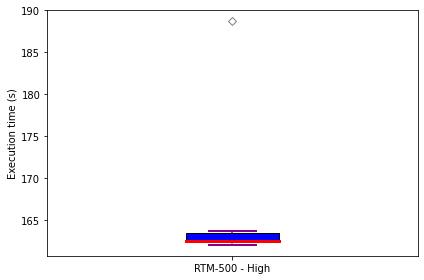


---------- TinySTM - High ----------


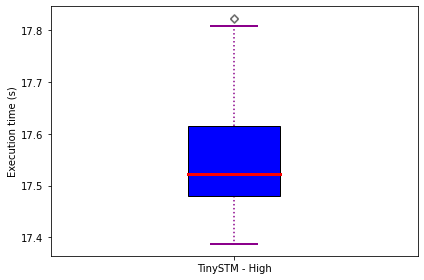


---------- SwissTM - High ----------


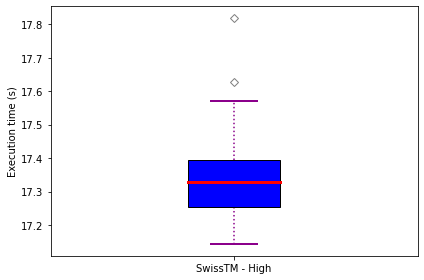

In [12]:
##bench_apply_boxplots("C")
#bench_apply_boxplots("HiContention")
bench_apply_boxplots("High")

### T-Test and U-Test

#### Low Contention

In [13]:
#bench_report_t_u_tests("B")
#if("LoContention" in CLASSES):
#  bench_report_t_u_tests("LoContention")
if("Low" in CLASSES):
  bench_report_t_u_tests("Low")

               (RTM-1[Low]) x (RTM-50[Low])
         KS OK?                         No
       T-Test p         6.163134747051e-05
    T-Test stat                -4.53492248
 T-Test p<=0.05      Not normally distrib.
       U-Test p         1.479276809093e-12
    U-Test stat                 0.00000000
 U-Test p<=0.05                  U-Test OK


#### High Contention

In [14]:
##bench_report_t_u_tests("C")
#if "HiContention" in CLASSES:
#  bench_report_t_u_tests("HiContention")
if "High" in CLASSES:
  bench_report_t_u_tests("High")

               (RTM-1[High]) x (RTM-50[High])
         KS OK?                         No
       T-Test p         5.535443884005e-05
    T-Test stat                -4.57058499
 T-Test p<=0.05      Not normally distrib.
       U-Test p         2.598295687016e-12
    U-Test stat                 0.00000000
 U-Test p<=0.05                  U-Test OK


### Speedup charts

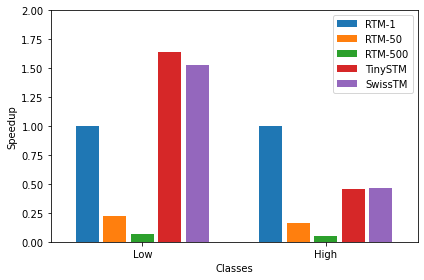

In [15]:
#O speedup to comparando uma execução com ela mesma, isso preciso mudar

##Aqui provavelmente tenha que mudar
##Aqui usa as questões de versão e classe que não sei se traduzi corretamente pro meu caso
#print('----------', "Python", '----------')
#versions_gpu = [VER_PYTHON_CUDA]
#versions = [VER_RTM_INTEL_R1]
#versions2 = ["VER_RTM_INTEL_R1", "VER_STM_TINY", "VER_STM_SWISS"]

#bench_speedup_chart(VER_PYTHON_SERIAL, versions_gpu)
#bench_speedup_chart(VER_RTM_INTEL, versions)
#bench_speedup_chart(VER_RTM_INTEL_R1, versions)
#for v in VERSIONS:
v = VERSIONS[0]
bench_speedup_chart(v, VERSIONS)


#print("\n\n", '----------', "C++", '----------')
#if g_bench == "IS":
#    versions_gpu = [VER_CUDA]
#else:
#    versions_gpu = [VER_CUDA, VER_OPENACC]
#versions = [VER_SEQ]
#versions = [VER_STM_TINY]

#bench_speedup_chart(VER_CPP_SERIAL, versions_gpu)
#bench_speedup_chart(VER_SEQ, versions)
#bench_speedup_chart(VER_STM_TINY, versions)

### GPU comparison chart

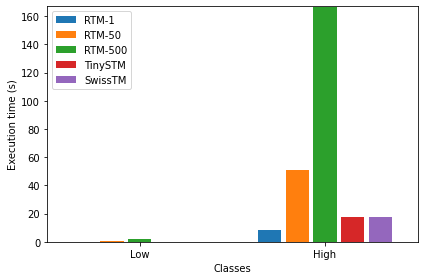

In [16]:
bench_time_chart()

## Main general view

### Utils

In [17]:
def load_npb_data_dictinary():
    global dic_dados_bench
    global dic_dados
    for b in BENCHS:
        dic_dados = {}
        load_data_dictionary(b)
        dic_dados_bench[b] = dict(dic_dados)
#END

In [18]:
##Aqui também tive que mudar bastante coisa com classes e versões e não sei se tá correto
def npb_time_chart(classe):
	times = []
	bench_ids = range(1, len(BENCHS)*2+1, 2)
	
	#for v in VERSIONS_GPU:
	for v in VERSIONS:
		v_time = []
		
		for bench in BENCHS:
			dic_bench = dic_dados_bench[bench]
			if idx_dicionario(v, classe) in dic_bench.keys():
				time, a, b = calc_stats(dic_bench[idx_dicionario(v, classe)]["times"])
			else:
				time = 0.0
			v_time.append(time)
			
		times.append(v_time)
	
	#Chart
	#desenha as barras no gráfico
	fig, ax = plt.subplots()
	
	bars = []
	idx = -0.5
	for t in times:
		bar = ax.bar(np.array(bench_ids)+idx, np.array(t), width=0.45)
		bars.append(bar)
		idx += 0.5

	ax.set_xlabel('Benchmark')
	ax.set_ylabel('Execution time (s)')
	ax.set_xlim(0, 16)
	ax.set_ylim(0.01, 60)
	
	ax.set_title('Execution time') 
	ax.legend(tuple(map(name_versao, VERSIONS)))
	
	ax.set_xticks(bench_ids)
	ax.set_xticklabels(BENCHS)
	
	#ax.set_yscale('log', base=2)
	ax.set_yscale('log') 
	
	locs = [0.05, 0.1, 0.5, 1, 5, 10, 20, 40, 60]
	ax.yaxis.set_minor_locator(ticker.FixedLocator(locs))
	ax.yaxis.set_major_locator(ticker.NullLocator())

	ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())
	
	#for b in bars:
	#	ax.bar_label(b, padding=3, fmt='%4.2f')

	fig.tight_layout()

	plt.show() #mostra o gráfico
#END

def npb_speedup_chart(classe):
	speedups = []
	bench_ids = range(1, len(BENCHS)*2+1, 2)
	
	#for v in VERSIONS_GPU:
	for v in VERSIONS:
		v_speedup = []
		
		for bench in BENCHS:
			dic_bench = dic_dados_bench[bench]
			
			if idx_dicionario(v, classe) in dic_bench.keys():
				time_serial = 1.0
				#if "PYTHON" in v: 
				#	time_serial, a, b = calc_stats(dic_bench[idx_dicionario(VER_PYTHON_SERIAL, classe)]["times"])
				#time_serial, a, b = calc_stats(dic_bench[idx_dicionario(VER_RTM_INTEL, classe)]["times"])
				time_serial, a, b = calc_stats(dic_bench[idx_dicionario(VER_RTM_INTEL_R1, classe)]["times"])
				#else:
				#	time_serial, a, b = calc_stats(dic_bench[idx_dicionario(VER_CPP_SERIAL, classe)]["times"])
				#
				#if idx_dicionario(v, classe) in dic_bench.keys():
				time, a, b = calc_stats(dic_bench[idx_dicionario(v, classe)]["times"])
				v_speedup.append(time_serial/time)
			else:
				v_speedup.append(-100.0)
			
		speedups.append(v_speedup)
	
	#Chart
	#desenha as barras no gráfico
	fig, ax = plt.subplots()
	
	bars = []
	idx = -0.5
	for s in speedups:
		bar = ax.bar(np.array(bench_ids)+idx, np.array(s), width=0.45)
		bars.append(bar)
		idx += 0.5

	ax.set_xlabel('Benchmark')
	ax.set_ylabel('Speedup')
	ax.set_xlim(0, 16)
	ax.set_ylim(1, 2000)
	
	ax.set_title('Speedup') 
	ax.legend(tuple(map(name_versao, VERSIONS)))
	
	ax.set_xticks(bench_ids)
	ax.set_xticklabels(BENCHS)
	
	ax.set_yscale('log') 
	
	locs = [1, 5, 10, 50, 100, 500, 1000, 1500, 2000]
	ax.yaxis.set_minor_locator(ticker.FixedLocator(locs))
	ax.yaxis.set_major_locator(ticker.NullLocator())

	ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())
	
	#for b in bars:
	#	ax.bar_label(b, padding=3, fmt='%4.1f')

	fig.tight_layout()

	plt.show() #mostra o gráfico
#END

### Charts

Gerando bayes ...
bayes OK
Gerando genome ...
genome OK
Gerando intruder ...
intruder OK
Gerando kmeans ...
kmeans OK
Gerando labyrinth ...
labyrinth OK
Gerando ssca2 ...
ssca2 OK
Gerando vacation ...
vacation OK
Gerando yada ...
yada OK


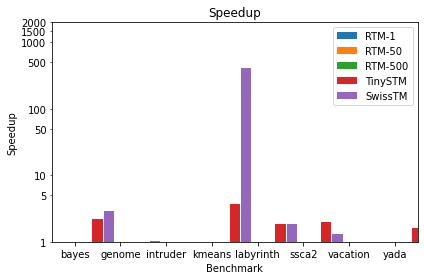

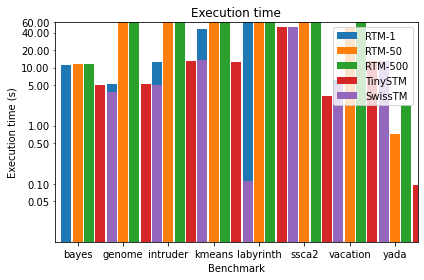

In [19]:
load_npb_data_dictinary()

#print('\n', '----------', "Class B", '----------')
#npb_speedup_chart("B")
#npb_speedup_chart("LoContention")
npb_speedup_chart("Low")

#npb_time_chart("B")
#npb_time_chart("LoContention")
npb_time_chart("Low")

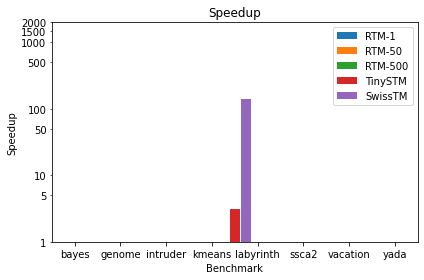

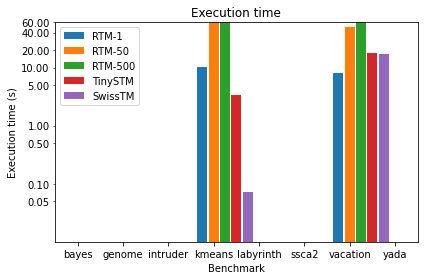

In [20]:
##print('\n', '----------', "Class C", '----------')
##npb_speedup_chart("C")
#if "HiContention" in CLASSES:
#  npb_speedup_chart("HiContention")
if "High" in CLASSES:
  npb_speedup_chart("High")

##npb_time_chart("C")
#  npb_time_chart("HiContention")
  npb_time_chart("High")

In [21]:
import os
get_ipython().system(
    "apt update >> /dev/null && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended >> /dev/null"
)

notebookpath="/content/drive/MyDrive/Colab Notebooks/"
file_name = "NPB_statistics - Frederico.ipynb"
drive_mount_point = "/content/drive/"
gdrive_home = os.path.join(drive_mount_point, "My Drive/Colab Notebooks/Arquivos")

if not os.path.isfile(os.path.join(notebookpath, file_name)):
  raise ValueError(f"file '{file_name}' not found in path '{notebookpath}'.")

pdfNum = 0
while os.path.isfile(os.path.join(gdrive_home, file_name.split(".")[0] + str(pdfNum) + ".pdf")):
  pdfNum = pdfNum + 1
filename = file_name.split(".")[0] + str(pdfNum)# + ".pdf"

try:
    get_ipython().system(
        "jupyter nbconvert --output-dir=\""+gdrive_home+"\" \""+notebookpath+file_name+"\" --to pdf --output=\""+filename+"\""
    )
except:
    print("nbconvert error")

try:
    from google.colab import files

    file_name = file_name.split(".")[0] + ".pdf"
    files.download(gdrive_home + file_name)
except:
    print("File Download Unsuccessful. Saved in Google Drive")

print("File ready to be Downloaded and Saved to Drive")





[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/NPB_statistics - Frederico.ipynb to pdf
[NbConvertApp] Support files will be in NPB_statistics - Frederico15_files/
[NbConvertApp] Making directory ./NPB_statistics - Frederico15_files
[NbConvertApp] Making directory ./NPB_statistics - Frederico15_files
[NbConvertApp] Making directory ./NPB_statistics - Frederico15_files
[NbConvertApp] Making directory ./NPB_statistics - Frederico15_files
[NbConvertApp] Making directory ./NPB_statistics - Frederico15_files
[NbConvertApp] Making directory ./NPB_statistics - Frederico15_files
[NbConvertApp] Making directory ./NPB_statistics - Frederico15_files
[NbConvertApp] Making directory ./NPB_statistics - Frederico15_files
[NbConvertApp] Making directory ./NPB_statistics - Frederico15_files
[NbConvertApp] Making directory ./NPB_statistics - Frederico15_files
[NbConvertApp] Making directory ./NPB_statistics - Frederico15_files
[NbConvertApp] Making directory ./NPB_statistic